In [1]:
import resourcecode
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plot
import matplotlib.tri as mtri
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
import seaborn as sns
import windrose as wrose

## Data selection and extraction from the Resourcecode database

In [2]:
points ={"N1": [59.01, 355.75],
         "N2": [58.87, 354.40],
         "N3": [58.73, 353.75],
         "N4": [58.45, 353.25]}

In [3]:
rscd_nodes=dict()
for p in points:
    rscd_nodes[p] = resourcecode.data.get_closest_point(latitude=points[p][0], longitude=points[p][1])[0]

In [4]:
rscd_nodes

{'N1': 274163, 'N2': 273984, 'N3': 277235, 'N4': 265617}

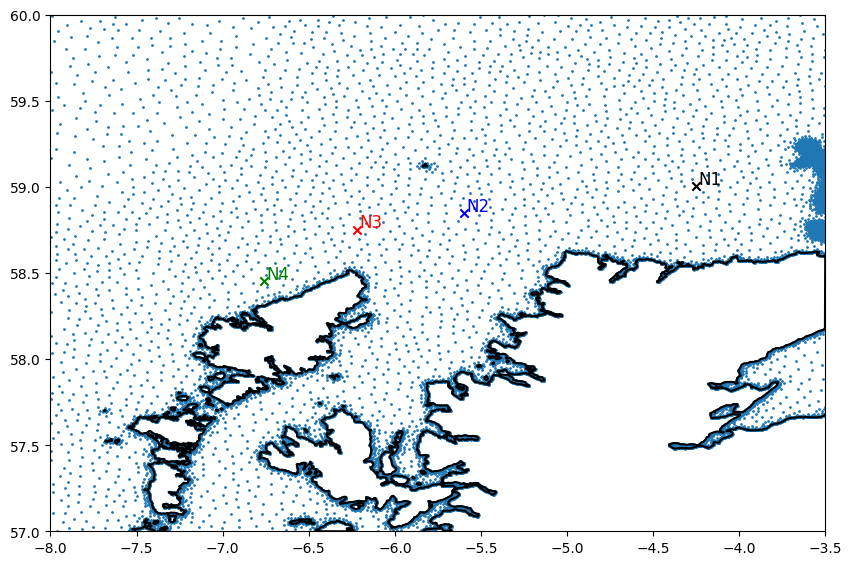

In [5]:
lat_min, lat_max = 57, 60
lon_min, lon_max = -8, -3.5

plot_colors = {"N1":"black",
               "N2":"blue",
               "N3":"red",
               "N4":"green"}

nodes = resourcecode.data.get_grid_field().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
spec = resourcecode.get_grid_spec().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
coast = resourcecode.data.get_coastline().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
islands = resourcecode.data.get_islands().query(
    f"latitude <= {lat_max} and latitude >= {lat_min} and longitude > {lon_min} and longitude < {lon_max}"
)
fig = plot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
plot.scatter(nodes.longitude, nodes.latitude, s=1, label="Nodes")
#plot.scatter(spec.longitude, spec.latitude, s=2, color="orange", label="Spectral grid")
plot.ylim(lat_min, lat_max)
plot.xlim(lon_min, lon_max)
plot.plot(coast.longitude, coast.latitude, color="black")
classes = list(islands.ID.unique())
for c in classes:
    df2 = islands.loc[islands["ID"] == c]
    plot.plot(df2.longitude, df2.latitude, color="black")
for node in rscd_nodes:
    plot.scatter(
        nodes.loc[rscd_nodes[node]-1].longitude,
        nodes.loc[rscd_nodes[node]-1].latitude,
        marker='x',
        color=plot_colors[node],
        label=node
    )
    plot.annotate(node,
                xy=(nodes.loc[rscd_nodes[node]-1].longitude,
                    nodes.loc[rscd_nodes[node]-1].latitude),
                xycoords='data', size=12,
                color=plot_colors[node],
                xytext=(1.5, 1.5), textcoords='offset points')
plot.show()

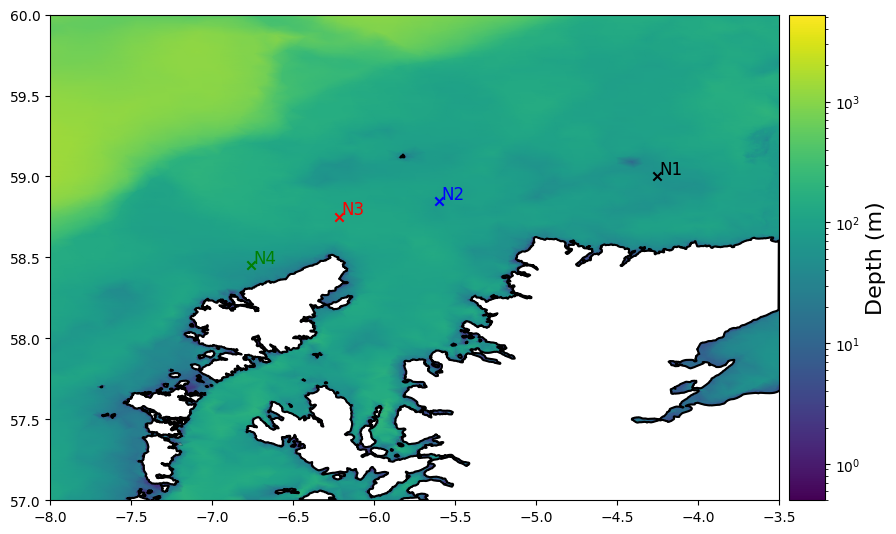

In [6]:
# Importing the data for plotting
tri = (
    resourcecode.get_triangles().to_numpy() - 1
)  # The '-1' is due to the Zero-based numbering of python
field_mesh = resourcecode.data.get_grid_field().to_numpy()
triang = mtri.Triangulation(field_mesh[:, 1], field_mesh[:, 2], tri)

plotted_nodes = (
    (field_mesh[:, 1] <= lon_max)
    & (field_mesh[:, 1] >= lon_min)
    & (field_mesh[:, 2] <= lat_max)
    & (field_mesh[:, 2] >= lat_min)
)

s = field_mesh[:, 3]
s[np.isnan(s)] = 0  # Due to missing values in bathy

fig = plot.figure(figsize=(10, 10))

ax0 = fig.add_subplot(111, aspect="equal")

plot.ylim(lat_min, lat_max)
plot.xlim(lon_min, lon_max)
SC = ax0.tripcolor(triang, s, shading="gouraud")
SC.set_clim(min(s[plotted_nodes]), max(s[plotted_nodes]))
SC.set_norm(matplotlib.colors.LogNorm())
# Plot selected locations
for node in rscd_nodes:
    plot.scatter(
        nodes.loc[rscd_nodes[node]-1].longitude,
        nodes.loc[rscd_nodes[node]-1].latitude,
        marker='x',
        color=plot_colors[node],
        label=node
    )
    plot.annotate(node,
                xy=(nodes.loc[rscd_nodes[node]-1].longitude,
                    nodes.loc[rscd_nodes[node]-1].latitude),
                xycoords='data', size=12,
                color=plot_colors[node],
                xytext=(1.5, 1.5), textcoords='offset points')
# Add coastlines and islands
plot.plot(coast.longitude, coast.latitude, color="black")
classes = list(islands.ID.unique())
for c in classes:
    df2 = islands.loc[islands["ID"] == c]
    plot.plot(df2.longitude, df2.latitude, color="black")

# Colorbar.
the_divider = make_axes_locatable(ax0)
color_axis = the_divider.append_axes("right", size="5%", pad=0.1)
cbar = plot.colorbar(SC, cax=color_axis)
cbar.set_label("Depth (m)", fontsize=16)
plot.show()

### Downloading the data if needed

The data is not stored in the repository, so il is possible to download it with the code chunks bellow. Just uncomment it and run it.

In [7]:
#client = resourcecode.Client()
#data_rscd = dict()
#for p in rscd_nodes:
#    dat = client.get_dataframe(
#        pointId=rscd_nodes[p],
#        startDateTime="1994-01-01T01:00:00",
#        endDateTime="2020-01-01T00:00:00",
#        parameters=("hs", "uwnd", "vwnd", "tp", "dp"))
#    dat["wspd"], dat["wdir"] = resourcecode.utils.zmcomp2metconv(dat.uwnd, dat.vwnd)
#    dat["wspd_100m"] = dat["wspd"]*(100/10)**0.14 # From the paper, to converte from 10m wind to hub-height
#    data_rscd[p]=dat

In [8]:
# #Saving the data for future use
# for p in rscd_nodes:
#    data_rscd[p].to_netcdf('data/'+p+'.nc')

The chunck below loads previously downloaded data

In [13]:
import xarray as xr
data_rscd = dict()
for p in rscd_nodes:
   data_rscd[p] = xr.open_dataset('data/'+p+'.nc').to_dataframe()

In [38]:
df = pd.concat(data_rscd).reset_index(names=['Location','Time'])
df['Month'] = df['Time'].dt.strftime('%b')
df

Location                Time     hs  uwnd  vwnd         tp     dp  \
0            N1 1994-01-01 00:00:00  2.490   5.6   4.4  14.492754  266.0   
1            N1 1994-01-01 01:00:00  2.452   5.8   4.2  14.285714  265.0   
2            N1 1994-01-01 02:00:00  2.450   5.7   4.1  14.084507  266.0   
3            N1 1994-01-01 03:00:00  2.482   5.5   4.0  13.698630  268.0   
4            N1 1994-01-01 04:00:00  2.550   5.9   3.7  13.513514  268.0   
...         ...                 ...    ...   ...   ...        ...    ...   
911611       N4 2019-12-31 19:00:00  2.888   6.8   8.8   9.900990  279.0   
911612       N4 2019-12-31 20:00:00  2.972   6.6   8.9   9.523810  278.0   
911613       N4 2019-12-31 21:00:00  3.016   6.0   9.4   9.433962  276.0   
911614       N4 2019-12-31 22:00:00  2.986   4.3   9.2   9.523810  274.0   
911615       N4 2019-12-31 23:00:00  2.942   4.5   9.9   9.523810  273.0   

             wspd        wdir  wspd_100m Month  
0        7.121798  231.842773   9.830817   Jan  
1        7.161006  234.090277   9.884939   Jan  
2        7.021396  234.272602   9.692224   Jan  
3        6.800735  233.972627   9.387628   Jan  
4        6.964194  237.907409   9.613264   Jan  
...           ...         ...        ...   ...  
911611  11.121151  217.694240  15.351462   Dec  
911612  11.080162  216.559635  15.294882   Dec  
911613  11.151681  212.550003  15.393606   Dec  
911614  10.155294  205.050978  14.018208   Dec  
911615  10.874741  204.443955  15.011322   Dec  

[911616 rows x 11 columns]

## Descriptive statistics at selected locations

### Sea-state variability

#### Seasonal variability

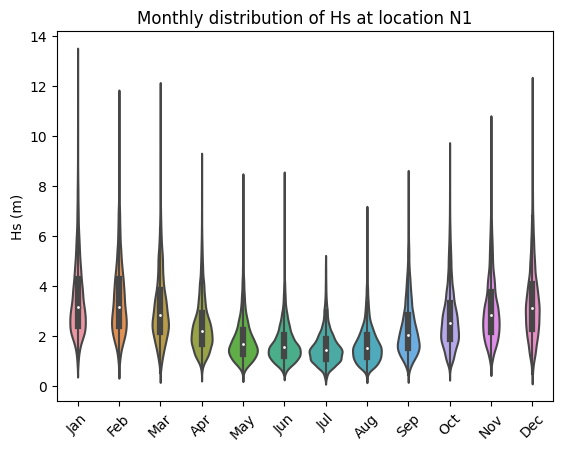

In [10]:
fig = sns.violinplot(data_rscd['N1'],x=data_rscd['N1'].index.strftime('%b'),y='hs') # .strftime('%b') is for abreviated months names
fig.set(xlabel=None)
fig.set(title="Monthly distribution of Hs at location N1")
fig.set(ylabel="Hs (m)")
plot.xticks(rotation=45);

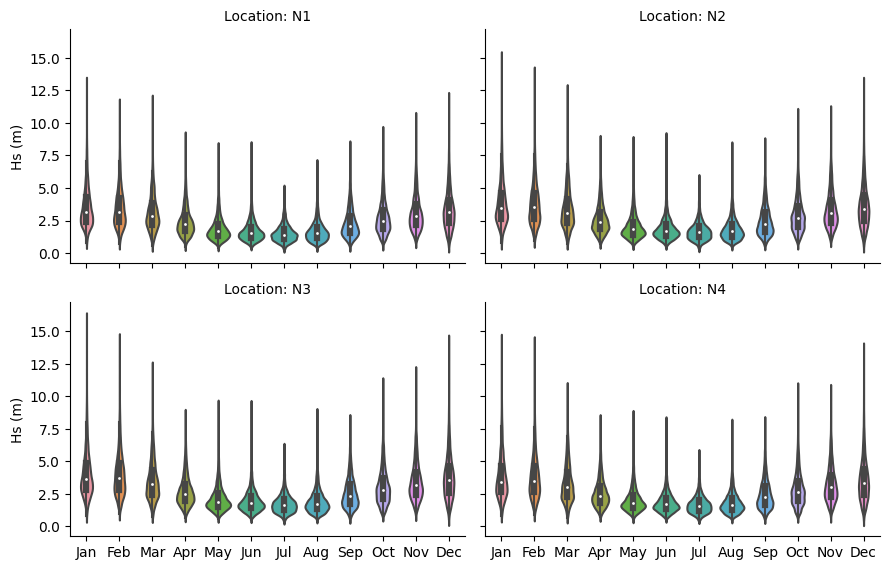

In [45]:
g = sns.catplot(data=df,x='Month',y='hs',col='Location',col_wrap=2,kind='violin',height=3,aspect=1.5)
g.set_axis_labels("", "Hs (m)");
g.set_titles("{col_var}: {col_name}");

#### Wave roses (figure 9)

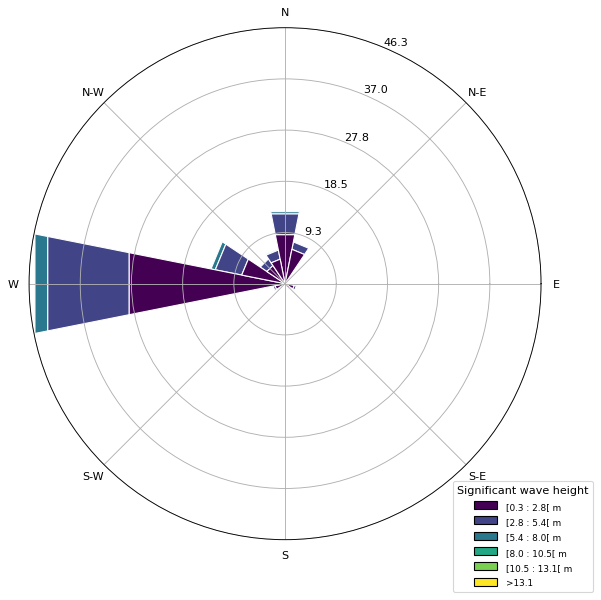

In [12]:
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
ax = wrose.WindroseAxes.from_ax(theta_labels=new_labels)
ax.bar(data_rscd['N1'].dp,data_rscd['N1'].hs,normed=True, opening=1, edgecolor='white')
ax.set_legend(title='Significant wave height',units="m",loc='lower right', bbox_to_anchor=(1.1, -0.1));

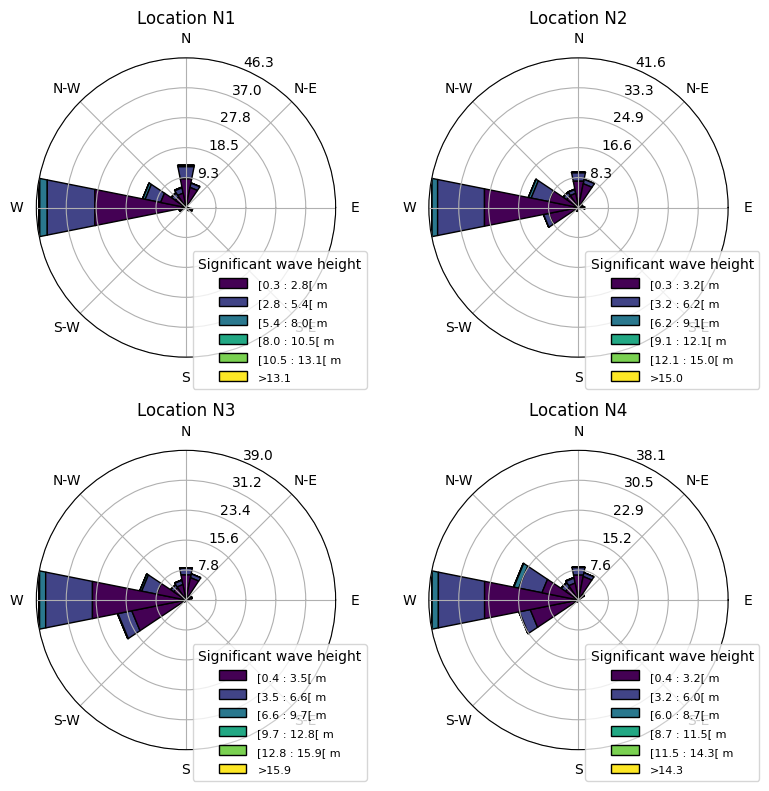

In [13]:
fig = plot.figure(figsize=(6.5,6.5))
for i in range(4):
    dat = data_rscd[list(data_rscd)[i]]
    ax = fig.add_subplot(2, 2,i+1, projection="windrose")
    ax.set_title("Location "+list(data_rscd)[i])
    ax.bar(dat.dp,dat.hs,normed=True, opening=1, edgecolor='black')
    ax.set_legend(title='Significant wave height',units="m",loc='lower right', bbox_to_anchor=(1.1, -0.1));
plot.tight_layout()

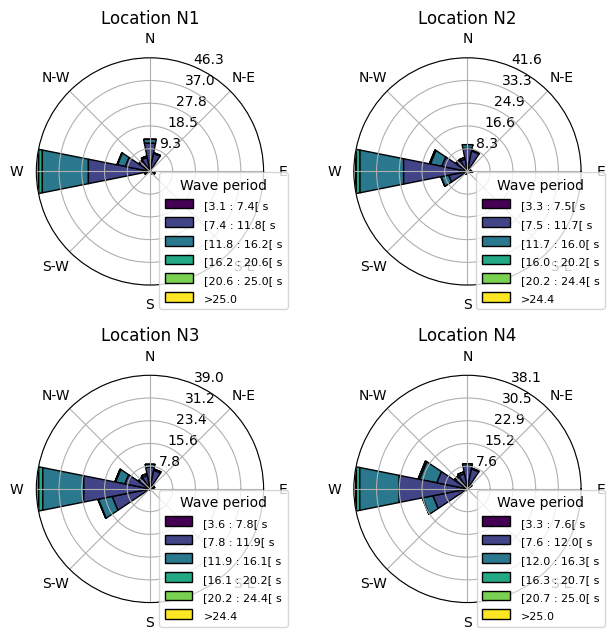

In [48]:
fig = plot.figure(figsize=(6.5,6.5))
for i in range(4):
    dat = data_rscd[list(data_rscd)[i]]
    ax = fig.add_subplot(2, 2,i+1, projection="windrose")
    ax.set_title("Location "+list(data_rscd)[i])
    ax.bar(dat.dp,dat.tp,normed=True, opening=1, edgecolor='black')
    ax.set_legend(title='Wave period',units="s",loc='lower right', bbox_to_anchor=(1.1, -0.1));
plot.tight_layout()

### Wind speed at 170 m height

#### seasonal variability

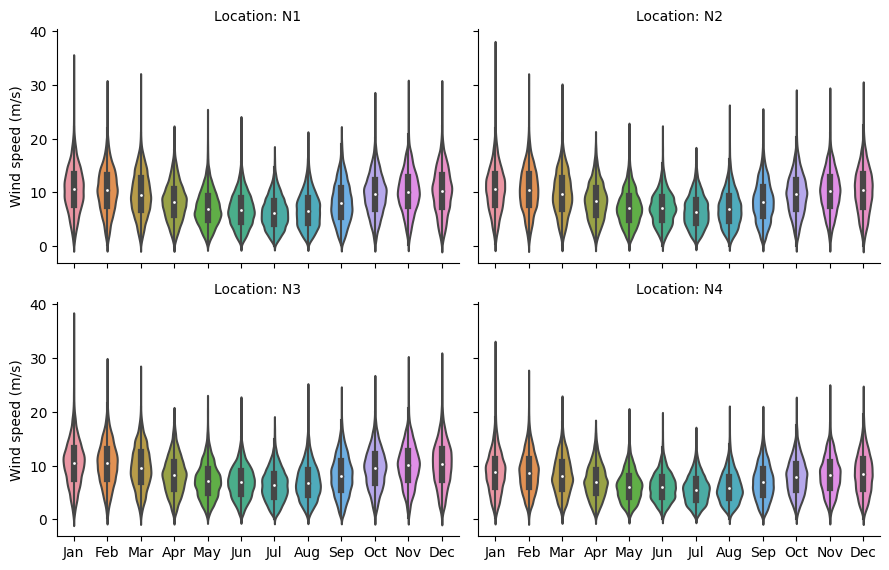

In [51]:
g = sns.catplot(data=df,x='Month',y='wspd',col='Location',col_wrap=2,kind='violin',height=3,aspect=1.5)
g.set_axis_labels("", "Wind speed (m/s)");
g.set_titles("{col_var}: {col_name}");

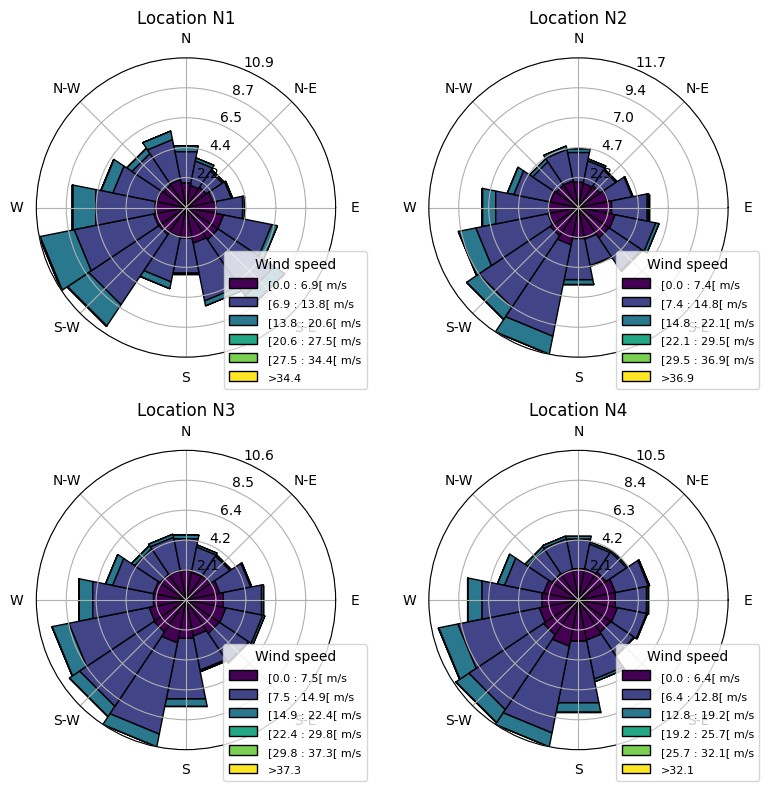

In [50]:
fig = plot.figure(figsize=(8,8))
for i in range(4):
    dat = data_rscd[list(data_rscd)[i]]
    ax = fig.add_subplot(2, 2,i+1, projection="windrose")
    ax.set_title("Location "+list(data_rscd)[i])
    ax.bar(dat.wdir,dat.wspd,normed=True, opening=1, edgecolor='black')
    ax.set_legend(title='Wind speed',units="m/s",loc='lower right', bbox_to_anchor=(1.1, -0.1));
plot.tight_layout()

## Computation of the accessibility

We next define the constraints for computing the operationnal windows

In [17]:
vessel_constraints = {
    "Cable Laying":"hs < 1",
    "CTV": 'hs < 1.8',
    "Offshore access system": "hs < 2",
    "SOV": "hs < 3.5",
    "Helicopter": "wspd_100m < 20",
    "Drone": "wspd_100m < 10"
}

In [18]:
percentiles = [0.25, 0.5, 0.75]
weather_window = dict()
for vessel in vessel_constraints:
    for point in rscd_nodes:
        data_matching_criteria = data_rscd[point].eval('cond = '+ vessel_constraints[vessel]) #Compute a bool value corresponding to constraint
        df_grouped = data_matching_criteria.groupby(pd.Grouper(freq="M")) # Compute summary statistics on monthly basis (Year and Month)
        accessibility = df_grouped['cond'].mean().to_frame() #C Accessibility is the proportion of values above the threshold
        accessibility['cond'] = accessibility['cond']*100 # Convert to %
        accessibility['Year']=accessibility.index.year 
        accessibility['Month']=accessibility.index.month
        weather_window[point,vessel] = accessibility.groupby('Month')['cond'].describe() #Compute summary values by month

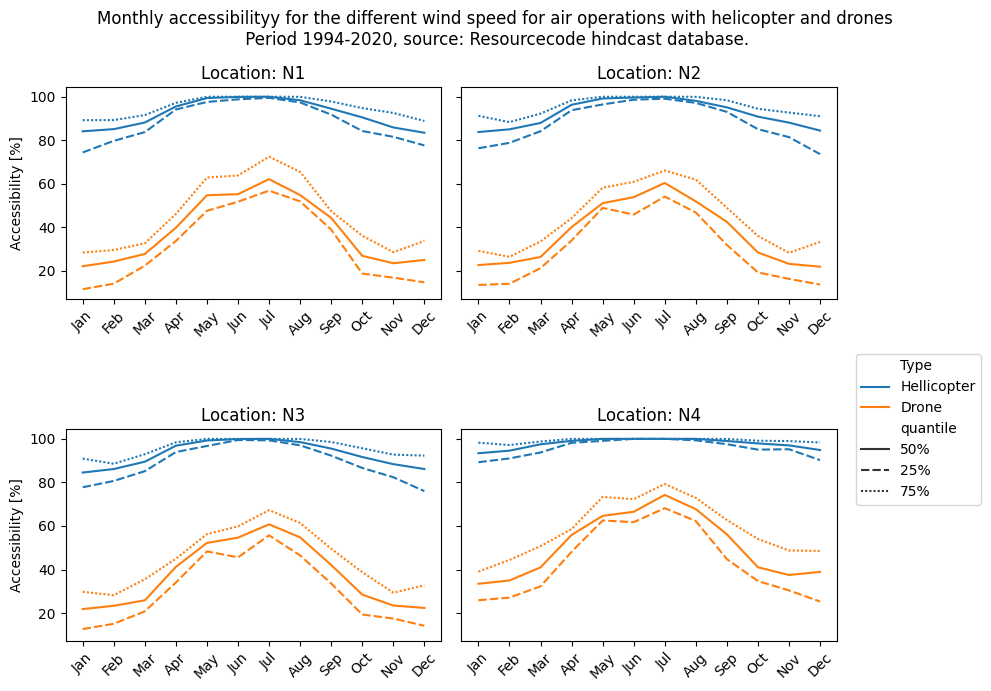

In [19]:
fig, axes = plot.subplots(2, 2, figsize=(10, 7),sharey=True)
fig.suptitle('Monthly accessibilityy for the different wind speed for air operations with helicopter and drones\n Period 1994-2020, source: Resourcecode hindcast database.')
for i in range(4):
    data_Hellicopter = weather_window[list(data_rscd)[i],'Helicopter']
    data_Drone = weather_window[list(data_rscd)[i],'Drone']
    data_Hellicopter['Type']='Hellicopter'
    data_Drone['Type']='Drone'
    data = pd.concat([data_Hellicopter,data_Drone])
    data['Mnth']=pd.to_datetime(data.index, format='%m').strftime('%b')
    sf = sns.lineplot(data=data[['Type','Mnth','50%','25%','75%']].melt(['Type','Mnth'],var_name='quantile'),ax=axes.reshape(-1)[i],x='Mnth',y='value',hue="Type",style='quantile')
    sf.set(xlabel=None)
    sf.set(title="Location: "+list(data_rscd)[i])
    sf.set(ylabel="Accessibility [%]")
    sf.legend_.remove()
    axes.reshape(-1)[i].tick_params(axis='x', rotation=45)
plot.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
plot.tight_layout()

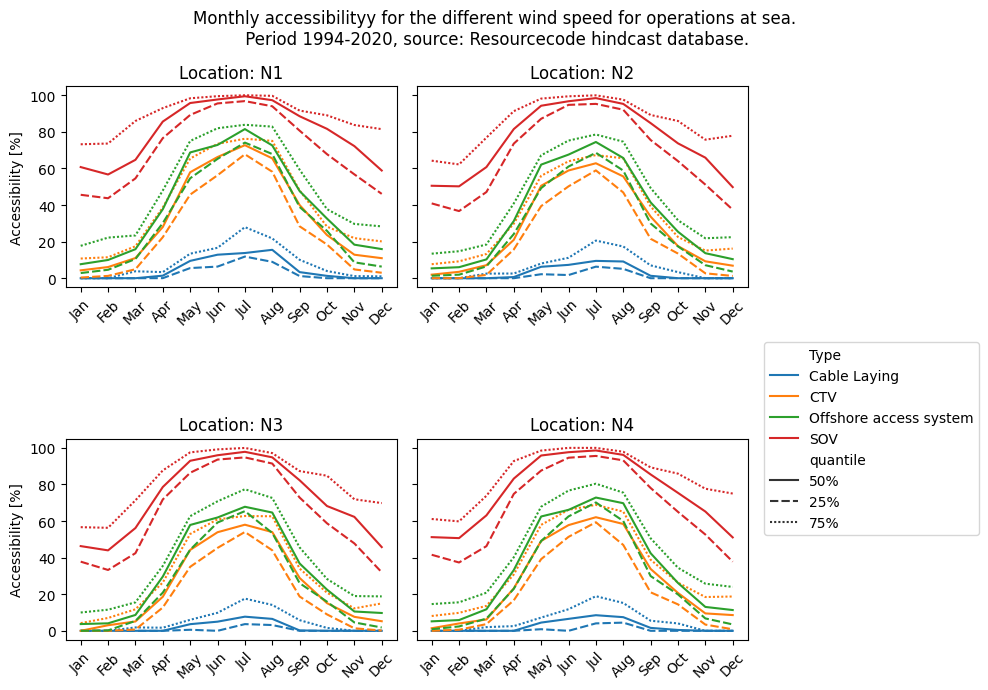

In [20]:
fig, axes = plot.subplots(2, 2, figsize=(10, 7),sharey=True)
fig.suptitle('Monthly accessibilityy for the different wind speed for operations at sea.\n Period 1994-2020, source: Resourcecode hindcast database.')
for i in range(4):
    data_Cable = weather_window[list(data_rscd)[i],'Cable Laying']
    data_CTV = weather_window[list(data_rscd)[i],'CTV']
    data_OAS = weather_window[list(data_rscd)[i],'Offshore access system']
    data_SOV = weather_window[list(data_rscd)[i],'SOV']
    data_Cable['Type']='Cable Laying'
    data_CTV['Type']='CTV'
    data_OAS['Type']='Offshore access system'
    data_SOV['Type']='SOV'
    data = pd.concat([data_Cable,data_CTV,data_OAS,data_SOV])
    data['Mnth']=pd.to_datetime(data.index, format='%m').strftime('%b')
    sf = sns.lineplot(data=data[['Type','Mnth','50%','25%','75%']].melt(['Type','Mnth'],var_name='quantile'),ax=axes.reshape(-1)[i],x='Mnth',y='value',hue="Type",style='quantile')
    sf.set(xlabel=None)
    sf.set(title="Location: "+list(data_rscd)[i])
    sf.set(ylabel="Accessibility [%]")
    sf.legend_.remove()
    axes.reshape(-1)[i].tick_params(axis='x', rotation=45)
plot.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
plot.tight_layout()